# Model Training

Here is the summary of what we do in this section

Metrics we will be using to evaluate our model:
1. F-score (Can be intepreted as the weighted average between precision and recall): <br />
The reason we used F-score and not precision and recall because precision is how good the model predict the rating correctly and recall is how good the model recall most of the rating. We hope that our model are not only able to predict precisely and also able to recall most of the movie of that rating, that why we see F-score
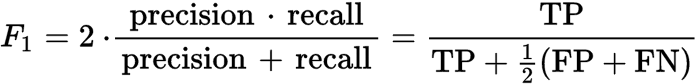
Source: https://www.gstatic.com/education/formulas2/355397047/en/f1_score.svg
2. Classification Accuracy (Accuracy in classification report):
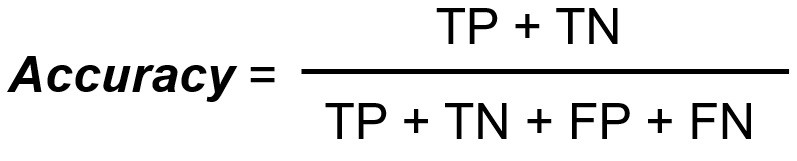
Source:https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fdecoding-the-confusion-matrix-bb4801decbb&psig=AOvVaw3vuF65tmA7TtxhRdk8RvX4&ust=1619174524238000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNjPvKTVkfACFQAAAAAdAAAAABAD

To determine a whether a certain feature is significant:
1. Importance/Gini importance: Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits. (https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3#:~:text=Gini%20Importance%20%2F%20Mean%20Decrease%20in%20Impurity%20(MDI)&text=Gini%20Importance%20or%20Mean%20Decrease%20in%20Impurity%20(MDI)%20calculates%20each,number%20of%20samples%20it%20splits.)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

Read the csv file

In [2]:
df = pd.read_csv("movie_data.csv")
df.head()

,id,runtime,genres,keywords,production_companies,age_rating,budget
0,527774,107.0,"['Animation', 'Adventure', 'Fantasy', 'Family'...","['kung fu', 'trip', 'sword', 'warrior woman', ...","['Walt Disney Pictures', 'Walt Disney Animatio...",PG,0
1,587807,101.0,"['Action', 'Comedy', 'Family', 'Animation', 'A...","['computer animation', 'racial stereotype', 'l...","['Warner Animation Group', 'Warner Bros. Pictu...",PG,50000000
2,484718,110.0,['Comedy'],"['africa', 'prince', 'heir to the throne', 'se...","['Paramount', 'New Republic Pictures', 'Eddie ...",PG-13,60000000
3,458576,104.0,"['Fantasy', 'Action', 'Adventure']","['female soldier', 'another dimension', 'bow a...","['CAPCOM', 'Constantin Film', 'Impact Pictures...",PG-13,60000000
4,464052,151.0,"['Fantasy', 'Action', 'Adventure']","['dc comics', 'superhero', 'based on comic', '...","['DC Entertainment', 'Warner Bros. Pictures', ...",PG-13,200000000


We notice that the list structure inside genres, keywords and producton_companies was string and not list (due to we download it as csv file, so we do the following code to convert them).

In [3]:
df['genres'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', '))  if(s2[1:-1]!="")]     for s in df['genres'] ]
df['keywords'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', '))  if(s2[1:-1]!="")]     for s in df['keywords']]
df['production_companies'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', ')) if(s2[1:-1]!="")]     for s in df['production_companies']]
df['age_rating'] = df['age_rating'].astype('category')
df.head()

,id,runtime,genres,keywords,production_companies,age_rating,budget
0,527774,107.0,"[Animation, Adventure, Fantasy, Family, Action]","[kung fu, trip, sword, warrior woman, computer...","[Walt Disney Pictures, Walt Disney Animation S...",PG,0
1,587807,101.0,"[Action, Comedy, Family, Animation, Adventure]","[computer animation, racial stereotype, live a...","[Warner Animation Group, Warner Bros. Pictures...",PG,50000000
2,484718,110.0,[Comedy],"[africa, prince, heir to the throne, sequel, q...","[Paramount, New Republic Pictures, Eddie Murph...",PG-13,60000000
3,458576,104.0,"[Fantasy, Action, Adventure]","[female soldier, another dimension, bow and ar...","[CAPCOM, Constantin Film, Impact Pictures, Ten...",PG-13,60000000
4,464052,151.0,"[Fantasy, Action, Adventure]","[dc comics, superhero, based on comic, 1980s, ...","[DC Entertainment, Warner Bros. Pictures, The ...",PG-13,200000000


# Data Modelling

### 1. Changing the data into One-Hot Encoding

Before we can train our models, we will have to change the categorical data in one-hot encoded form as scikit does not support categorical data in its native form.


One-hot encoding separates the different categories of each variable into different columns, and if that particular row has a certain category or categories, the respective category columns will be 1 while the rest will be 0.

During the one_hot_encoding, we drop 'id' because it is just an indicator of movie_id, was not used during the model training

In [4]:
def one_hot_encoding(df):
    mlb = MultiLabelBinarizer()
    df = df.dropna()
    df = df.drop(["id"], axis=1)
    ## Reason
    
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('keywords')),
                          columns=mlb.classes_,
                          index=df.index))
    
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('genres')),
                              columns=mlb.classes_,
                              index=df.index))
    if('a'  in df.keys()):
        df = df.drop(['a'],axis=1)
    if('pride'  in df.keys()):
        df = df.drop(['pride'], axis=1)
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('production_companies')),
                              columns=mlb.classes_,
                              index=df.index))
    return df

In [5]:
df = one_hot_encoding(df)

### 2. Splitting Data into Train and Test Datasets

In order to effectively train our models and see how well they perform, we must split the data into train and test datasets. Here, we are splitting the data using a ratio of 0.33 to Test, and 0.67 to Train, meaning 4357 rows for Train and 2146 rows for Test.

In [6]:
df.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['age_rating'],axis=1), df['age_rating'] ,test_size=0.33, random_state=42)

## Model of Choice: Random Forest

Import Sklearn RandomForestClassifier and fit model using train dataset

What is a random forest?

A random forest model involves the use of many different classification trees, and the model does classification using different permutations of the variables used for each tree.

Inherently, the random forest model is better than a single classification tree as it prevents over-fitting of the model.

Furthermore, as shown in our exploratory data analysis, we have many outliers and features. Since random forest is less prone to noise/features which are less 'important' as well as outliers, it is one of the better choice as compared to other classification models.

### Step 1: Import necessary libraries

We import Sklearn RandomForestClassifier.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


### Step 2: Train the Random Forest Model Using the Train Data

We have our train data from above, so all we have to do is to use the random forest classifier on our train data.

In [8]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, random_state=0)

### Step 3: Model Evaluation using Train Data

Here, we get the classifications of age rating that the model has predicted and visualize it using countplot

<AxesSubplot:xlabel='Age Rating', ylabel='count'>

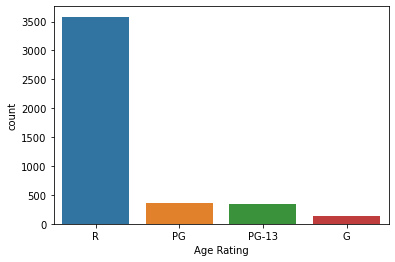

In [9]:
predict_train = pd.DataFrame(clf.predict(X_train), columns=['Age Rating'])
sb.countplot(data=predict_train, x='Age Rating')

We plot a confusion matrix to see the results of our random forest model on the train data

<AxesSubplot:>

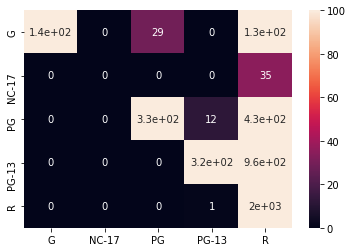

In [10]:
con = confusion_matrix(y_train, predict_train)
sb.heatmap(con, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

In order to see how well our model has done in prediction, we get classification report from sklearn.metrics. For more information, https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56.

In [11]:
report_A_train = classification_report(y_train, predict_train)
print(classification_report(y_train, predict_train))

              precision    recall  f1-score   support

           G       1.00      0.46      0.63       299
       NC-17       0.00      0.00      0.00        35
          PG       0.92      0.43      0.59       773
       PG-13       0.96      0.25      0.40      1280
           R       0.57      1.00      0.72      2032

    accuracy                           0.64      4419
   macro avg       0.69      0.43      0.47      4419
weighted avg       0.77      0.64      0.59      4419



C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Step 4: Model Evaluation using Test Data

Here, we get the classifications of age rating that the model has predicted using test data and we do the same procedure using Test Data

<AxesSubplot:xlabel='Age Rating', ylabel='count'>

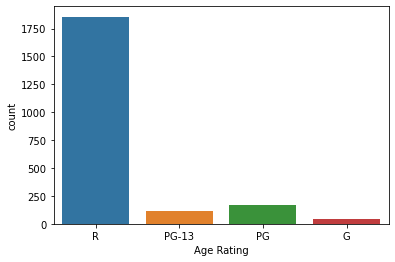

In [12]:
predict_test = pd.DataFrame(clf.predict(X_test), columns=['Age Rating'])
sb.countplot(data=predict_test, x='Age Rating')

<AxesSubplot:>

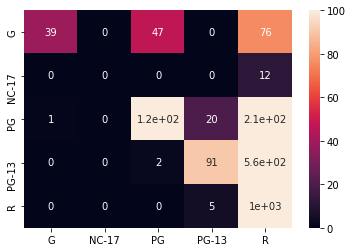

In [13]:
con = confusion_matrix(y_test, predict_test)
sb.heatmap(con, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

In [14]:
report_A_test = classification_report(y_test, predict_test)
print(report_A_test)

              precision    recall  f1-score   support

           G       0.97      0.24      0.39       162
       NC-17       0.00      0.00      0.00        12
          PG       0.70      0.33      0.45       349
       PG-13       0.78      0.14      0.24       652
           R       0.54      1.00      0.70      1002

    accuracy                           0.57      2177
   macro avg       0.60      0.34      0.35      2177
weighted avg       0.67      0.57      0.49      2177



C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Observation: The accuracy is 0.57 and it is quite low

Therefore from now onward, we are doing model optimization

# Model Improvement Strategies

### Utility Function: Data Modelling Pipeline

In accordance to the DRY principle, we create a utility function that executes our data modelling pipeline

In [16]:
def random_forest_pipeline(y_train, X_train, y_test, X_test, max_depth):
    '''
    Procedures:
    1. Fit model with train data with specified maximum depth.
    2. Return predicted data classification reports and its confusion matrix
    '''
    clf = RandomForestClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X_train,y_train)
    predict_train = pd.DataFrame(clf.predict(X_train), columns=['Age Rating'])
    predict_test = pd.DataFrame(clf.predict(X_test), columns=['Age Rating'])
    report_train = classification_report(y_train, predict_train)
    report_test = classification_report(y_test, predict_test)
    con_train = confusion_matrix(y_train, predict_train)
    con_test = confusion_matrix(y_test, predict_test)
    
    return predict_train, predict_test, report_train\
            , report_test, con_train, con_test, clf

## Model Improvement 1: Optimizing Hyperparameters

First, we find the most suitable hyperparameter for max_depth of random forest

### Step 1: Finding the suitable hyperparameter for max_depth

In [62]:
descent = { "train":[], "test":[], "depth":[]}
for i in range(10,125):
    clf = RandomForestClassifier(max_depth=i, random_state=0)
    clf.fit(X_train,y_train)
    
    predict_train = clf.predict(X_train)
    con2 = confusion_matrix(y_train, predict_train)
    train_size = X_train.shape[0]
    correct = 0
    for j in range(0,5):
        correct += con2[j][j]
    train_classification_accuracy = correct/train_size

    predict = clf.predict(X_test)
    con = confusion_matrix(y_test, predict)
    test_size = y_test.shape[0]
    correct = 0
    for j in range(0,5):
        correct += con[j][j]
    classification_accuracy = correct/test_size
    
    descent['train'].append(train_classification_accuracy)
    descent['test'].append(classification_accuracy)
    descent['depth'].append(i)

In [63]:
df_descent = pd.DataFrame(descent)
df_descent

,train,test,depth
0,0.496492,0.488287,10
1,0.505544,0.492421,11
2,0.520706,0.499770,12
3,0.531116,0.505742,13
4,0.545146,0.514469,14
...,...,...,...
110,0.979633,0.702343,120
111,0.978276,0.699587,121
112,0.980765,0.699587,122
113,0.981896,0.704180,123


### Step 2: Visualize the improvement to find the most balanced point
We plot the graph of train accuracy against max_depth and test accuracy against max_depth

In [64]:
for i in range(1,101):
    descent['depth'][i-1]=i

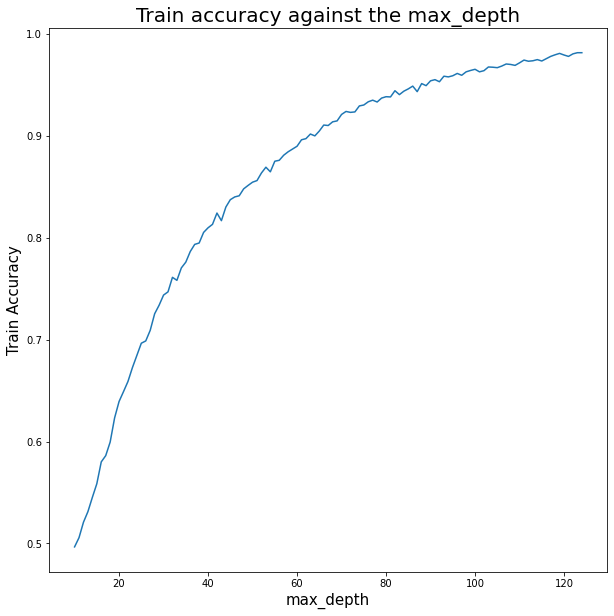

In [82]:
f = plt.figure(figsize=(10,10))
ax =sb.lineplot(data = df_descent, x='depth',y='train')
ax.set_title ("Train accuracy against the max_depth", size = 20)
ax.set_xlabel("max_depth", size = 15)
plt.xticks(fontsize=10)
ax.set_ylabel("Train Accuracy", size = 15)
plt.yticks(fontsize=10)

plt.show()


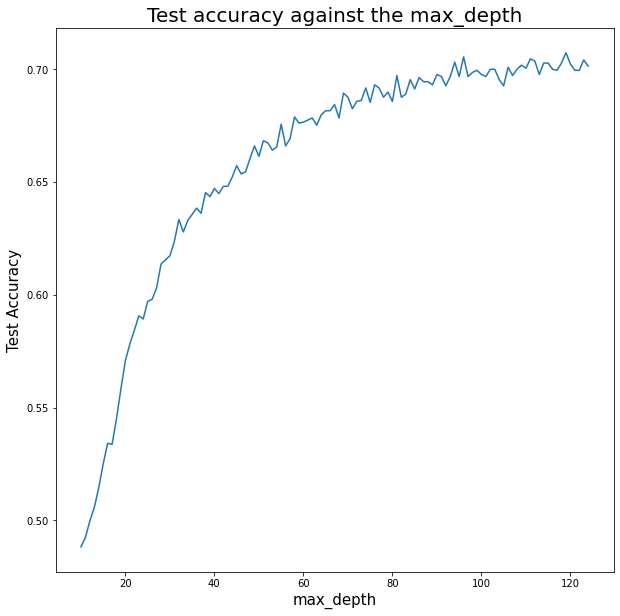

In [83]:
f = plt.figure(figsize=(10,10))
ax = sb.lineplot(data = df_descent, x='depth',y='test')
ax.set_title ("Test accuracy against the max_depth", size = 20)
ax.set_xlabel("max_depth", size = 15)
plt.xticks(fontsize=10)
ax.set_ylabel("Test Accuracy", size = 15)
plt.yticks(fontsize=10)

plt.show()


We can see that the more depth it train, the train_accuracy increase but the test accuracy actually fluatrated.
The flutrated of the test accuracy are too hard for us to predict the best max_depth (we know it is somewhere around 80-100 as it is the point where improvement of train_accuracy become linear and improvement of test accuracy fluatrated around a constant). So we plot the improvement of test accuracy to determine the exact point

### Step 3: Plot the improvement in test data

In [92]:
df_descent['test improvement'] = [ val-df_descent['test'][max(0,i-1)] for i , val in enumerate(df_descent['test']) ]
df_descent

,train,test,depth,test improvement
0,0.496492,0.488287,10,0.000000
1,0.505544,0.492421,11,0.004134
2,0.520706,0.499770,12,0.007350
3,0.531116,0.505742,13,0.005972
4,0.545146,0.514469,14,0.008728
...,...,...,...,...
110,0.979633,0.702343,120,-0.005053
111,0.978276,0.699587,121,-0.002756
112,0.980765,0.699587,122,0.000000
113,0.981896,0.704180,123,0.004593


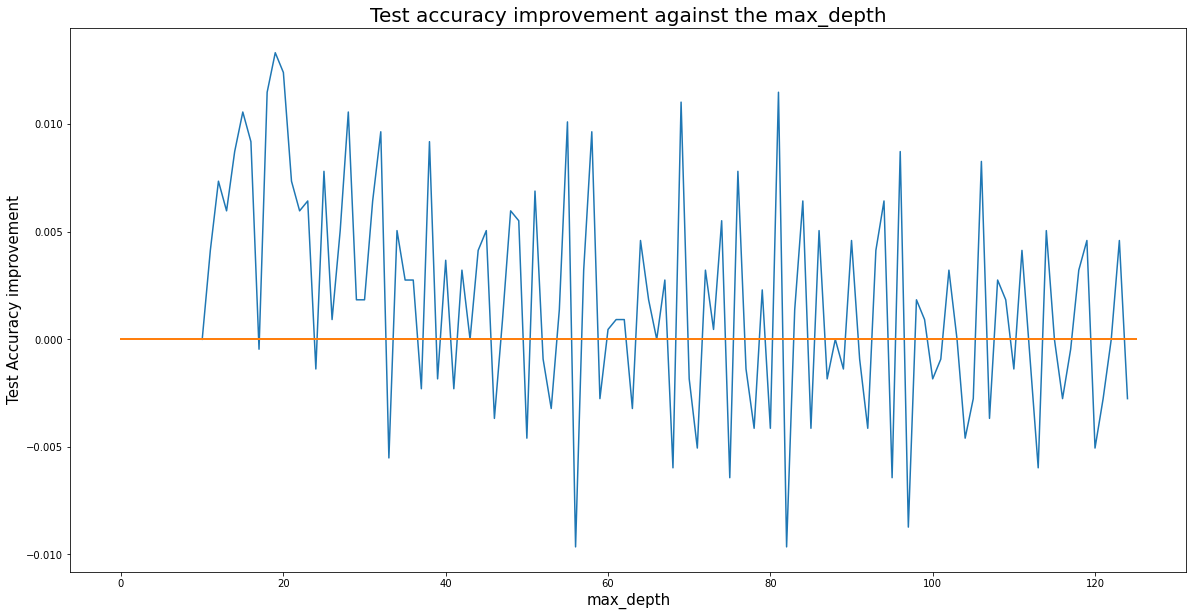

In [97]:
f = plt.figure(figsize=(20,10))
ax = sb.lineplot(data = df_descent, x='depth',y='test improvement')
ax.set_title ("Test accuracy improvement against the max_depth", size = 20)
ax.set_xlabel("max_depth", size = 15)
plt.xticks(fontsize=10)
ax.set_ylabel("Test Accuracy improvement", size = 15)
plt.yticks(fontsize=10)
plt.plot([0, 125], [0, 0], linewidth=2)
plt.show()


We understand that the number of depth increases the training time of the model (Trade off)
Hence we need to find the optimal depth value, we can see that from 60 to 80, although there a fluatration, but there are still have continuous improvement. After 80, the improvement was fluatrated alternatively (one increase, one decrease). 81 have the most improvement so we found to be 81

In [15]:
max_depth = 81

### Step 2: Retrain Model with optimum max_depth

In [17]:
predict_train, predict_test\
, report_B_train, report_B_test\
, con_train, con_test, clf_B = random_forest_pipeline(y_train, X_train, y_test, X_test, max_depth)

<AxesSubplot:>

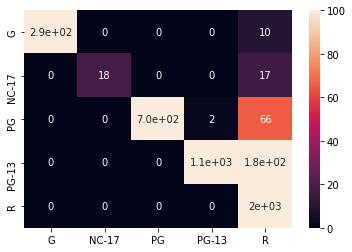

In [18]:
sb.heatmap(con_train, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

<AxesSubplot:>

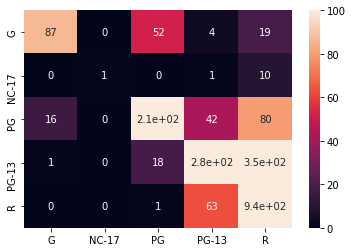

In [19]:
sb.heatmap(con_test, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

Comparison of Classification Reports

Report A:
Classification report taken from fitting random forest with max_depth = 20
without optimising the hyperparameter max_depth

Report B:
Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth

In [20]:
print("----------------")
print("Train Data")
print("----------------")
print("A: Classification report taken from fitting random forest with max_depth = 20\n")
print(report_A_train)
print("\n")
print("B: Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth\n")
print(report_B_train)
print("\n")
print("----------------")
print("Test Data")
print("----------------")
print("A: Classification report taken from fitting random forest with max_depth = 20\n")
print(report_A_test)
print("\n")
print("B: Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth\n")
print(report_B_test)
print("\n")

----------------
Train Data
----------------
A: Classification report taken from fitting random forest with max_depth = 20

              precision    recall  f1-score   support

           G       1.00      0.46      0.63       299
       NC-17       0.00      0.00      0.00        35
          PG       0.92      0.43      0.59       773
       PG-13       0.96      0.25      0.40      1280
           R       0.57      1.00      0.72      2032

    accuracy                           0.64      4419
   macro avg       0.69      0.43      0.47      4419
weighted avg       0.77      0.64      0.59      4419



B: Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth

              precision    recall  f1-score   support

           G       1.00      0.97      0.98       299
       NC-17       1.00      0.51      0.68        35
          PG       1.00      0.91      0.95       773
       PG-13       1.00      0.86      0.92

Observation: The model accuracy by test data is 0.70 which is an great improvement from accuracy of 0.57. 

Insights: The model at its current stage is good for predicting R (with f1-score of 0.78) and to some extent PG and G (f1-score of 0.67 and 0.65), however it is not very good at predicting NC-17 (with f1-score of 0.15). However for our use case, which is to be an overall age rating recommender, it does not work very well.

###  Model Improvement 2: Adding more NC-17 movies into our dataset

Refer to data_exploration notebook for the source code



### Step 1: Read the csv file with additional data and format the file (as same as above)

In [21]:
df = pd.read_csv("movie_data_NC_17_additional.csv")
df.head()

,id,runtime,genres,keywords,production_companies,age_rating,budget
0,527774,107.0,"['Animation', 'Adventure', 'Fantasy', 'Family'...","['kung fu', 'trip', 'sword', 'warrior woman', ...","['Walt Disney Pictures', 'Walt Disney Animatio...",PG,0
1,587807,101.0,"['Action', 'Comedy', 'Family', 'Animation', 'A...","['computer animation', 'racial stereotype', 'l...","['Warner Animation Group', 'Warner Bros. Pictu...",PG,50000000
2,484718,110.0,['Comedy'],"['africa', 'prince', 'heir to the throne', 'se...","['Paramount', 'New Republic Pictures', 'Eddie ...",PG-13,60000000
3,458576,104.0,"['Fantasy', 'Action', 'Adventure']","['female soldier', 'another dimension', 'bow a...","['CAPCOM', 'Constantin Film', 'Impact Pictures...",PG-13,60000000
4,464052,151.0,"['Fantasy', 'Action', 'Adventure']","['dc comics', 'superhero', 'based on comic', '...","['DC Entertainment', 'Warner Bros. Pictures', ...",PG-13,200000000


In [22]:
df['genres'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', '))  if(s2[1:-1]!="")]     for s in df['genres'] ]
df['keywords'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', '))  if(s2[1:-1]!="")]     for s in df['keywords']]
df['production_companies'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', ')) if(s2[1:-1]!="")]     for s in df['production_companies']]
df['age_rating'] = df['age_rating'].astype('category')
df.head()

,id,runtime,genres,keywords,production_companies,age_rating,budget
0,527774,107.0,"[Animation, Adventure, Fantasy, Family, Action]","[kung fu, trip, sword, warrior woman, computer...","[Walt Disney Pictures, Walt Disney Animation S...",PG,0
1,587807,101.0,"[Action, Comedy, Family, Animation, Adventure]","[computer animation, racial stereotype, live a...","[Warner Animation Group, Warner Bros. Pictures...",PG,50000000
2,484718,110.0,[Comedy],"[africa, prince, heir to the throne, sequel, q...","[Paramount, New Republic Pictures, Eddie Murph...",PG-13,60000000
3,458576,104.0,"[Fantasy, Action, Adventure]","[female soldier, another dimension, bow and ar...","[CAPCOM, Constantin Film, Impact Pictures, Ten...",PG-13,60000000
4,464052,151.0,"[Fantasy, Action, Adventure]","[dc comics, superhero, based on comic, 1980s, ...","[DC Entertainment, Warner Bros. Pictures, The ...",PG-13,200000000


One_hot_encoding

In [23]:
df = one_hot_encoding(df)
df.head()

,runtime,age_rating,budget,007,10th century,11th century,12th century,13th century,13th century bc,14th century,...,saban,shanghai gigantic pictures,td.,truTV,uFilm,uFund,uMedia Family,ufotable,Ánima Estudios,Árpád Productions
0,107.0,PG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101.0,PG,50000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,110.0,PG-13,60000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,104.0,PG-13,60000000,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,151.0,PG-13,200000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Step 2: Refit model and output confusion matrix and classification report

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['age_rating'],axis=1),
                                                    df['age_rating'] ,test_size=0.33, random_state=42)


predict_train, predict_test\
, report_C_train, report_C_test\
, con_train, con_test, clf_C = random_forest_pipeline(y_train, X_train, y_test, X_test, max_depth)

<AxesSubplot:>

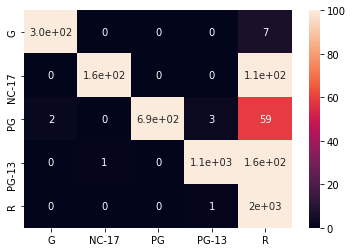

In [25]:
sb.heatmap(con_train, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

<AxesSubplot:>

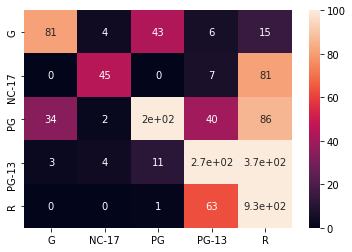

In [26]:
sb.heatmap(con_test, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

Comparison between classification report

Report B:
Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth


Report C:
Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data


In [27]:
print("----------------")
print("Train Data")
print("----------------")
print("B: Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth\n")
print(report_B_train)
print("\n")
print("C: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data\n")
print(report_C_train)
print("\n")
print("----------------")
print("Test Data")
print("----------------")
print("B: Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth\n")
print(report_B_test)
print("\n")
print("C: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data\n")
print(report_C_test)
print("\n")

----------------
Train Data
----------------
B: Classification report taken from fitting random forest with max_depth = 81 after optimising the hyperparameter max_depth

              precision    recall  f1-score   support

           G       1.00      0.97      0.98       299
       NC-17       1.00      0.51      0.68        35
          PG       1.00      0.91      0.95       773
       PG-13       1.00      0.86      0.92      1280
           R       0.88      1.00      0.94      2032

    accuracy                           0.94      4419
   macro avg       0.98      0.85      0.90      4419
weighted avg       0.94      0.94      0.94      4419



C: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data

              precision    recall  f1-score   support

           G       0.99      0.98      0.99       312
       NC-17       0.99      0.58      0.73       273
          PG       1.00      0.92      0.96       757
       PG-13    

Train Observations: 

There is a small drop of accuracy (0.70 to 0.66). Individually, PG and R have a small drop in f-score. However the f1-score for NC-17 has increased from 0.15 to 0.48. 

Insights: 

This shows that the previous problem, the lack of NC-17 data did affect our model's ability to predict NC-17 movies. Overall, adding more NC-17 data did bring us closer to our goal of having a more balanced age rating predictor for movies.

### Model Improvement 3: Removing less significant features based on 'importance'

### Step 1: Show the "importance" of each features

In [28]:
importances = list(clf_C.feature_importances_)
feature_list = list(X_train.columns)

feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

pd.DataFrame(feature_importances, columns=["features", "importance"])

,features,importance
0,Family,0.054199
1,runtime,0.033782
2,budget,0.026670
3,Animation,0.023904
4,Thriller,0.018749
...,...,...
17817,micro_scope,0.000000
17818,nc,0.000000
17819,shanghai gigantic pictures,0.000000
17820,truTV,0.000000


### Step 2: Get the features that have no significance to Age Ratings

In [29]:
feature_drop = [feature for feature, importance in zip(feature_list, importances) if importance==0]
pd.DataFrame(feature_drop, columns=['feature'])### Step 2: Get the features that have no significance to Age Ratings

,feature
0,11th century
1,13th century
2,1750s
3,1790s
4,2070s
...,...
5411,micro_scope
5412,nc
5413,shanghai gigantic pictures
5414,truTV


### Step 3: Drop features that have no significance to Age Ratings

In [30]:
df_drop_useless = df.drop(feature_drop, axis=1)
df_drop_useless

,runtime,age_rating,budget,007,10th century,12th century,13th century bc,14th century,15th century,16th century,...,nWave Pictures,nc.,pride,saban,td.,uFilm,uFund,uMedia Family,ufotable,Ánima Estudios
0,107.0,PG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101.0,PG,50000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,110.0,PG-13,60000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,104.0,PG-13,60000000,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,151.0,PG-13,200000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6954,90.0,NC-17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6955,82.0,NC-17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6956,112.0,NC-17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6957,85.0,NC-17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Step 4: Retrain model with new dataset and generate its classification report
Generate reports and confusion matrix using the utility function

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_drop_useless.drop(['age_rating'],axis=1),
                                                    df_drop_useless['age_rating'] ,test_size=0.33, random_state=42)


predict_train, predict_test\
, report_D_train, report_D_test\
, con_train, con_test, clf_D = random_forest_pipeline(y_train, X_train, y_test, X_test, max_depth)

<AxesSubplot:>

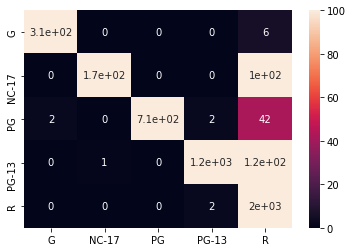

In [32]:
sb.heatmap(con_train, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

<AxesSubplot:>

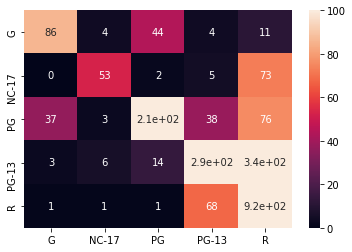

In [33]:
sb.heatmap(con_test, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

Comparison between Report 

Report C:
Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data

Report D:
Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating

In [34]:
print("----------------")
print("Train Data")
print("----------------")
print("C: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data\n")
print(report_C_train)
print("\n")
print("D: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating\n")
print(report_D_train)
print("\n")
print("----------------")
print("Test Data")
print("----------------")
print("C: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data\n")
print(report_C_test)
print("\n")
print("D: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating\n")
print(report_D_test)
print("\n")

----------------
Train Data
----------------
C: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data

              precision    recall  f1-score   support

           G       0.99      0.98      0.99       312
       NC-17       0.99      0.58      0.73       273
          PG       1.00      0.92      0.96       757
       PG-13       1.00      0.88      0.93      1275
           R       0.86      1.00      0.92      2043

    accuracy                           0.93      4660
   macro avg       0.97      0.87      0.91      4660
weighted avg       0.94      0.93      0.92      4660



D: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating

              precision    recall  f1-score   support

           G       0.99      0.98      0.99       312
       NC-17       0.99      0.63      0.77       273
          PG       1.00    

Test Observations: 

From the above classification reports, we note that there is a small increase in the accuracy rate for the overall prediction of age rating. There is also an minor increase in precision, recall and f1-score for most of the age rating categories.

Insights: 

The increase might not be significant because of how random forests/decision tree algorithm work. Given the fact that a decision tree will choose the feature which will give the highest information gain, the less important factors will likely not be chosen. Hence dropping less important features might not be very effective in improving the model

## Model Improvement 4: Use Word2Vec to form word clusters that are 'similar' to each other

Word2Vec is a pretrained NLP model that quantify 'words' to vectors of a certain magnitude. We then cluster the words together using K-Means Clustering which is an unsupervised learning clustering algorithm.

https://radimrehurek.com/gensim/models/word2vec.html


We use gensim to do word2Vec

In [35]:
from gensim.models import Word2Vec
from gensim.models import Phrases

C:\Users\USER\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Step 1: Get the list of keywords
We need to get a list of keywords for use in Word2Vec

In [36]:
df_word2Vec = pd.read_csv("movie_data_NC_17_additional.csv")
df_word2Vec['genres'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', '))  if(s2[1:-1]!="")]     for s in df_word2Vec['genres'] ]
df_word2Vec['keywords'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', '))  if(s2[1:-1]!="")]     for s in df_word2Vec['keywords']]
df_word2Vec['production_companies'] = [  [ s2[1:-1] for s2 in list(s[1:-1].split(', ')) if(s2[1:-1]!="")]     for s in df_word2Vec['production_companies']]
df_word2Vec['age_rating'] = df_word2Vec['age_rating'].astype('category')

In [37]:
list_of_keywords = list([keyword for keyword_list in df_word2Vec['keywords'] for keyword in keyword_list  ])
pd.DataFrame(list_of_keywords, columns = ['List of Key Words'])

#pd.Series(list_of_keywords).value_counts()

,List of Key Words
0,kung fu
1,trip
2,sword
3,warrior woman
4,computer animation
...,...
57397,erotic movie
57398,erotic movie
57399,prostitute
57400,seou


### Step 2: Train and Fit the vocabs of keywords into Word2Vec

#### Tuning Parameter  

##### Tuning the size
size =  200 <br />

After a few trying, after increase until certain size , there is no effect

##### Tuning the window
Window =  5  <br />

##### Tuning the min_count
min_count = 5 (because I want to take the significance data) <br />


##### Choose Between CBOW (0) or Skip-gram (1)
sg = 1 (Skip-Gram)

According to Mikolov

Skip-gram: works well with small amount of the training data, represents well even rare words or phrases.

CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words

Based on https://kavita-ganesan.com/comparison-between-cbow-skipgram-subword/#.YHa0A-gzaM8

The CBOW model learns to predict a target word leveraging all words in its neighborhood. The sum of the context vectors are used to predict the target word. The neighboring words taken into consideration is determined by a pre-defined window size surrounding the target word.

The SkipGram model on the other hand, learns to predict a word based on a neighboring word. To put it simply, given a word, it learns to predict another word in it’s context.

Based on that website, Task 2 :Finding Similarity Between Words, we can see that score_skipgram are higher in term of Negihboring concepts. That is what we want to use.


##### Tuning the hierarchial softmax (hs)
If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
I use hs = 1
based on 
https://code.google.com/archive/p/word2vec/ 
Hierarchical softmax is better for infrequent words
. The article does mention Skip-gram whcih is slower but better for infrequent words with further confirm the use of skip gram



Credit to https://medium.com/@makcedward/how-negative-sampling-work-on-word2vec-7bf8d545b116
(in understanding Hierarchial Softmax and negative Sampling)


##### Tuning alpha (initial Training rate)
The default is 0.025,
based on https://stackoverflow.com/questions/53815402/value-of-alpha-in-gensim-word-embedding-word2vec-and-fasttext-models,
In the stochastic gradient descent algorithm for adjusting the model, the effective alpha affects how strong of a correction to the model is made after each training example is evaluated, and will decay linearly from its starting value (alpha) to a tiny final value (min_alpha) over the course of all training.


In [38]:
model = Word2Vec([list_of_keywords], vector_size = 200, window= 5 ,workers=20, min_count = 5, sg = 1 , hs= 1 , negative= 0, epochs= 5 , compute_loss  = True ,sorted_vocab  = 1 )


### Step 3: Get groups by k-mean clustering

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [40]:
# get the vectors of the words
keywords_used = [word for word in list_of_keywords if word in model.wv.key_to_index]
keywords_used = list(set(keywords_used))

X = [model.wv.get_vector(word, norm=True)  for word in keywords_used]
print("Number of keywords_used in word2vec is" , len(keywords_used))

#Use k-mean to clustering
clusterK= 25

estimator = KMeans(init='k-means++', n_clusters=clusterK, n_init=30)
estimator.fit_predict(X)

# Assign groups if using clustering results
groups = [[] for n in range(clusterK)]
i=0
for w in keywords_used:
    group = estimator.labels_[i]
    groups[group].append(w)
    i+=1


Number of keywords_used in word2vec is 2462


We choose the number of cluster = 25, the reason is because there are 2462 keywords in total.
We roughly set averagely, there is 100 keywords in each groups.

Therefore we roughly set number of cluster = 2462/100 = 24.62 ~ 25 clusters

In [41]:
groups

[['1950s',
  'primal fear',
  'army',
  'climbing',
  'trapped',
  'jerusale',
  'flower',
  'leprechaun',
  'showdown',
  'decapitation',
  'liberation of prisoners',
  'bdsm',
  'maya civilization',
  'woods',
  'puppy',
  'genetic mutation',
  'psychologist',
  'tribe',
  'srael',
  'rags to riches',
  'british secret service',
  'foster family',
  'cia',
  'cannibal',
  'illegal immigration',
  'vision',
  'temple',
  'voyeurism',
  'halloween',
  'inanimate objects coming to life',
  'nature',
  'drug dealing',
  'airplane accident',
  'possession',
  'ransom',
  'driver',
  'terminal illness',
  'trainer',
  'chases and races',
  'helicopter',
  'captain',
  'catastrophe',
  'right and justice',
  'sexual fantasy',
  'despair',
  'knight',
  'parent child relationship',
  'shape shifter',
  'based on play or musical',
  'utah',
  'quarantine',
  'anti war',
  'sunlight',
  'earthquake',
  'bar fight',
  'arizona',
  'apocalypse',
  'kung fu',
  'racism',
  'subway train',
  'chil

### Step 4: Hash the keywords of the data into groups

In [42]:
hash_group = []
for keyword_list in df_word2Vec['keywords']:
    new =[]
    for keyword in keyword_list:
        j = 0
        for g in groups:
            if keyword in g:
                new.append("group " + str(j+1) )
                break
            j+=1
    hash_group.append(new)

In [43]:
df_word2Vec['keywords'] = hash_group
df_word2Vec.head()

,id,runtime,genres,keywords,production_companies,age_rating,budget
0,527774,107.0,"[Animation, Adventure, Fantasy, Family, Action]","[group 1, group 8, group 11, group 13, group 1...","[Walt Disney Pictures, Walt Disney Animation S...",PG,0
1,587807,101.0,"[Action, Comedy, Family, Animation, Adventure]","[group 11, group 11]","[Warner Animation Group, Warner Bros. Pictures...",PG,50000000
2,484718,110.0,[Comedy],"[group 11, group 6, group 9, group 9, group 11...","[Paramount, New Republic Pictures, Eddie Murph...",PG-13,60000000
3,458576,104.0,"[Fantasy, Action, Adventure]","[group 13, group 9, group 13, group 4]","[CAPCOM, Constantin Film, Impact Pictures, Ten...",PG-13,60000000
4,464052,151.0,"[Fantasy, Action, Adventure]","[group 4, group 4, group 4, group 4, group 11,...","[DC Entertainment, Warner Bros. Pictures, The ...",PG-13,200000000


### Step 5: Fit and Retrain the model

In [44]:
df_word2Vec = one_hot_encoding(df_word2Vec)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_word2Vec.drop(['age_rating'],axis=1),
                                                    df_word2Vec['age_rating'] ,test_size=0.33, random_state=42)


predict_train, predict_test\
, report_E_train, report_E_test\
, con_train, con_test, clf_E = random_forest_pipeline(y_train, X_train, y_test, X_test, max_depth+22)

<AxesSubplot:>

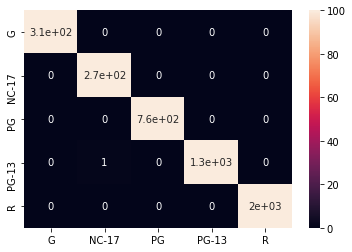

In [46]:
sb.heatmap(con_train, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

<AxesSubplot:>

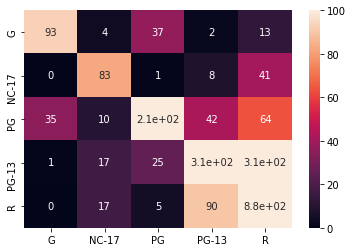

In [47]:
sb.heatmap(con_test, vmin=0, vmax=100, annot=True, yticklabels=['G','NC-17', 'PG', 'PG-13', 'R'], xticklabels=['G','NC-17', 'PG', 'PG-13', 'R'])

Comparison between Classification report

Report D:
Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating

Report E:
Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and clustering the keywords


In [49]:
print("----------------")
print("Train Data")
print("----------------")
print("D: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating\n")
print(report_D_train)
print("\n")
print("E: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and clustering the keywords\n")
print(report_E_train)
print("\n")
print("----------------")
print("Test Data")
print("----------------")
print("D: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating\n")
print(report_D_test)
print("\n")
print("E: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and clustering the keywords\n")
print(report_E_test)
print("\n")

----------------
Train Data
----------------
D: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and drop features that have no significance to the Age Rating

              precision    recall  f1-score   support

           G       0.99      0.98      0.99       312
       NC-17       0.99      0.63      0.77       273
          PG       1.00      0.94      0.97       757
       PG-13       1.00      0.91      0.95      1275
           R       0.88      1.00      0.94      2043

    accuracy                           0.94      4660
   macro avg       0.97      0.89      0.92      4660
weighted avg       0.95      0.94      0.94      4660



E: Classification report taken from fitting random forest with max_depth = 81 with additional NC-17 data and clustering the keywords

              precision    recall  f1-score   support

           G       1.00      1.00      1.00       312
       NC-17       1.00      1.00      1.00       273

Observation: 

Accuracy of model increase to 0.69. Individual categories of G, PG, PG-13 and R remains roughly similar. However, the f1-score for NC-17 has risen to 0.63.

Insights:

1st we just select the words with word_counts more than 5, which mean that, those words that lesser than 5 are excluded that means that we ignore the insignificant words. Furthermore, we cluster the words into 25 groups. This show that we greatly decrease the number of feature. which cause that each feature contains more number of data. (as previous some features only have one 1's). We believe that this would improve the model by further. Actually this show that the f-score for each rating are more balanced.

# Conclusion and Recommendation



## Feature Importances
We now want to rank the importances of the feature

### 1) All Feature Ranking

In [88]:
importances = list(clf_E.feature_importances_)
feature_list = list(X_train.columns)

feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

pd.DataFrame(feature_importances, columns=["group", "importance"]).head(20)

,group,importance
0,runtime,0.060112
1,Family,0.048178
2,budget,0.046495
3,Animation,0.023990
4,Adventure,0.020824
5,Thriller,0.019372
6,Comedy,0.015632
7,Horror,0.014122
8,group 2,0.013156
9,Crime,0.012803


Observation and Insight:
Based on the ranking,
Runtime is the most important feature while budget is the 3rd Important,

Actually this was quite surprising, because when we do data exploration we thought that it will not be significant but ended up runtime is the most significant

This show that runtime, budget are important feature in predicting age rating,

Family, Animation, Adventure, Thriller, Comedy ... These are genres,
an Group 2,5,14,21, these are keywords, 
So i would like to do a rank list of two of these.

Furthermore, none of the production companies appear in top 20, this might show that production companies was not that important in predicting the age_rating

### 2) Keywords Ranklist

Get the keywords of each group

In [76]:
groups_dict = {'group':['group '+ str(i) for i in range(1,clusterK+1)],'keywords':groups}

groups_df = pd.DataFrame(groups_dict)
groups_df 

,group,keywords
0,group 1,"[ex-wife, overdose, stupidity, beagle, deceive..."
1,group 2,"[tennessee, deja vu, soldier, b movie, tv news..."
2,group 3,"[alien, jazz singer or musician, mathematics, ..."
3,group 4,"[beauty salon, porn star, filmmaking, dancing,..."
4,group 5,"[tank, growing up, teacher, misfit, sewer, gen..."
5,group 6,"[folklore, mobster, lighthouse, gross out come..."
6,group 7,"[gift, cairo, death of daughter, screenwriter,..."
7,group 8,"[disorder, dentist, u.s. president, taxi, secr..."
8,group 9,"[vigilante justice, medieval, piano, sweden, i..."
9,group 10,"[hippie, cigarette smoking, work, great white ..."


In [77]:
importances = list(clf_E.feature_importances_)
feature_list = list(X_train.columns)

feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances) if feature in groups_df['group'].tolist()]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

groups_importance = pd.merge(pd.DataFrame(feature_importances, columns=["group", "importance"]),groups_df, on="group")
groups_importance

,group,importance,keywords
0,group 14,0.013641,"[mother son relationship, assistant, sequel, b..."
1,group 3,0.012275,"[alien, jazz singer or musician, mathematics, ..."
2,group 2,0.011932,"[tennessee, deja vu, soldier, b movie, tv news..."
3,group 5,0.011867,"[tank, growing up, teacher, misfit, sewer, gen..."
4,group 23,0.011241,"[dying and death, painting, plantation, san fr..."
5,group 22,0.010938,"[tourist, decapitation, female friendship, sla..."
6,group 18,0.010011,"[therapist, u.s. navy, attic, flat, teenage gi..."
7,group 15,0.009830,"[disaster, parent child relationship, writing,..."
8,group 25,0.009097,"[emperor, king arthur, drug dealer, hip-hop, a..."
9,group 13,0.008940,"[the white house, train, truck driver, jazz, i..."


Observation and Insight:
From all of this, we can know which keyword are rank most important lah , but indivisually doesn,t really meaning because some of the features need to have some correlation

### 3) Genres Ranklist



Get the list of Genres and Production Companies (For later use part 4)

In [92]:
df_variable = pd.read_csv("movie_data_NC_17_additional.csv")

list_of_genres = list(set([   s2[1:-1]    for s in df_variable['genres'] for s2 in list(s[1:-1].split(', '))  if(s2[1:-1]!="") ] ))
list_of_pc = list(set([   s2[1:-1]     for s in df_variable['production_companies'] for s2 in list(s[1:-1].split(', ')) if(s2[1:-1]!="")]))


Rank genres based on importance

In [94]:

importances = list(clf_E.feature_importances_)
feature_list = list(X_train.columns)

feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances) if feature in list_of_genres]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

genres_importance = pd.merge(pd.DataFrame(feature_importances, columns=["genres", "importance"]),pd.DataFrame(list_of_genres,columns=['genres']), on="genres")
genres_importance

,genres,importance
0,Family,0.048178
1,Animation,0.023990
2,Adventure,0.020824
3,Thriller,0.019372
4,Comedy,0.015632
5,Horror,0.014122
6,Crime,0.012803
7,Action,0.012341
8,Drama,0.012179
9,Fantasy,0.011483


Based on the genres, Family is most important feature (above 2 time the next rank), while western is not so important



### 4) Production Companies Ranklist

In [95]:

importances = list(clf_E.feature_importances_)
feature_list = list(X_train.columns)

feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances) if feature in list_of_pc]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

pc_importance = pd.merge(pd.DataFrame(feature_importances, columns=["production companies", "importance"]),pd.DataFrame(list_of_pc,columns=['production companies']), on="production companies")
pc_importance

,production companies,importance
0,Walt Disney Pictures,0.008305
1,Universal Pictures,0.005532
2,Paramount,0.005466
3,Warner Bros. Pictures,0.005011
4,Columbia Pictures,0.004651
...,...,...
6618,iWood Studios,0.000000
6619,micro_scope,0.000000
6620,nc,0.000000
6621,truTV,0.000000


In [96]:
pc_importance[pc_importance['importance']==0]

,production companies,importance
5029,"""Weathering With You"" Film Partners",0.0
5030,01 Distribution,0.0
5031,10 West Studios,0.0
5032,11:11 Mediaworks,0.0
5033,1212 Entertainment,0.0
...,...,...
6618,iWood Studios,0.0
6619,micro_scope,0.0
6620,nc,0.0
6621,truTV,0.0


Based on the production companies, 
All the production companies features are not so important, as the top feature is 0.008305  (Just better than 12th rank of genres) 
Some production companies features are not important at all (with zero) (there are 1594 features out of 6623)

## Visualize the trees

The next Outcome is the relationship between features.
Here we plot the 3 tree (out of 100 trees) and take until 5th depth (since the 81 depth is too much)

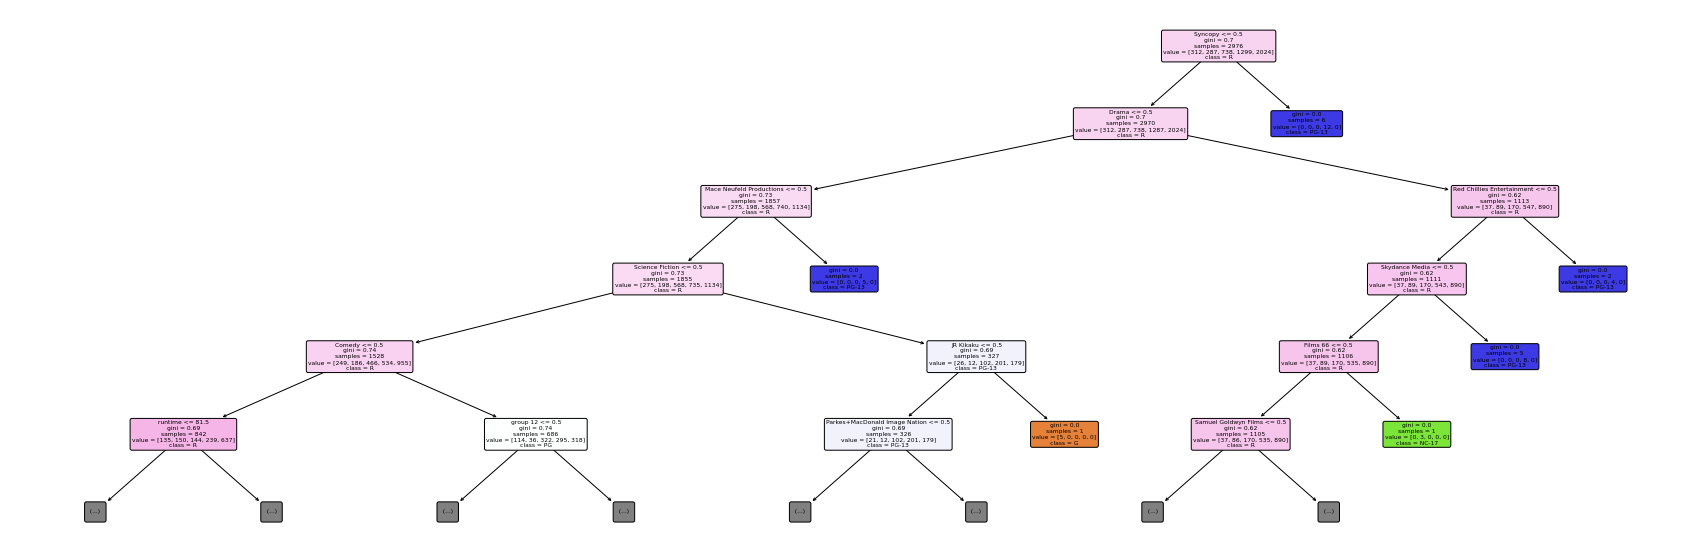

In [106]:
from sklearn import tree

fig = plt.figure(figsize=(30,10))
tree.plot_tree(clf_E.estimators_[1], 
                feature_names = X_train.columns,
                class_names = ['G','NC-17','PG','PG-13','R'],
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=5, fontsize = 6)
plt.savefig("decision_tree1.png", facecolor = 'white',dpi=100)

plt.show()

Due to the decision Trees are super large, here we just show a few insights

From the 1th-Tree, <br />
If a movie is not produced by Red Chillies Entertainment (not by Syncopy) and genre is drama, then it will be classifed as PG-13

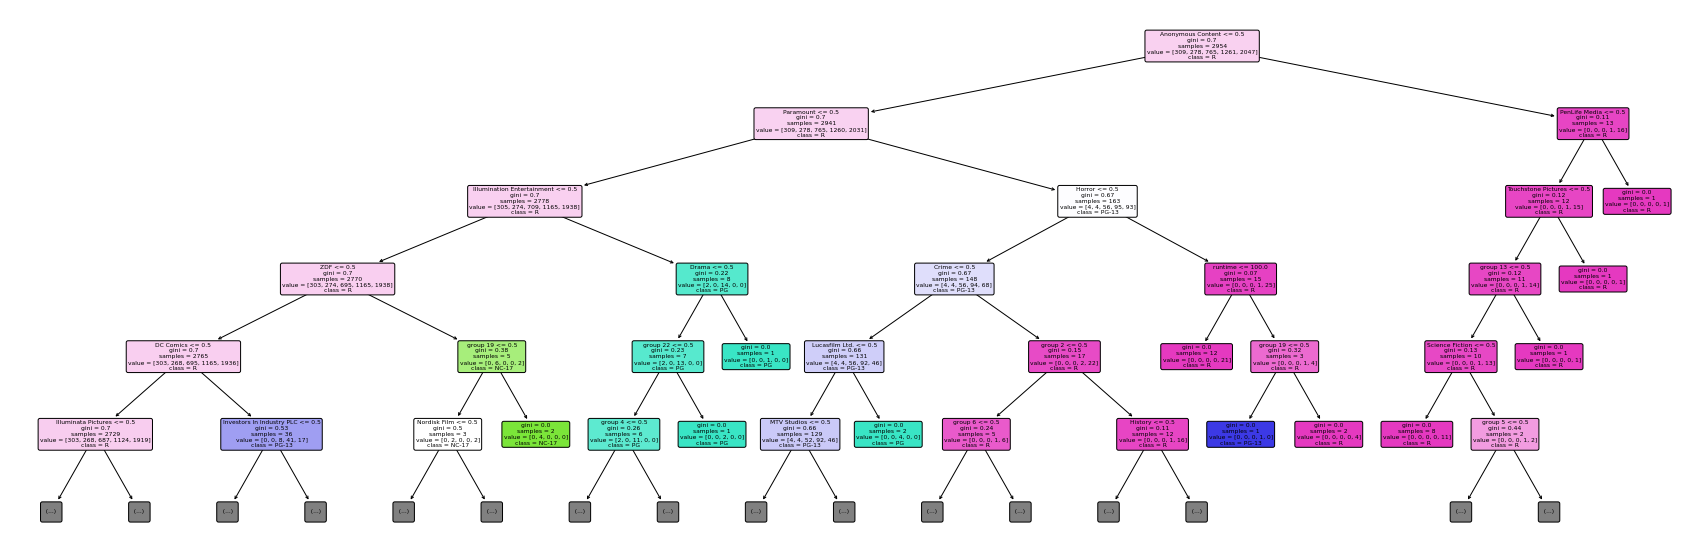

In [102]:
fig = plt.figure(figsize=(30,10))
tree.plot_tree(clf_E.estimators_[10], 
                feature_names = X_train.columns,
                class_names = ['G','NC-17','PG','PG-13','R'],
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=5, fontsize = 6)
plt.savefig("decision_tree2.png", facecolor = 'white',dpi=100)

plt.show()

Due to the decision Trees are super large, here we just show a few insights <br />

From the 10th-Tree, <br />
If a movie is produced by ZOF (not Illuminiation Entertainment, Paramunt, Anomynous content) and contains keywords  from Group 19, Then it will be classified as NC-17 by 10th Tree <br />

If a movie is produced by Illumination Entertainment (not paramount and anomynous content), and the genre is Drama, Then it will be classifed as PG <br />


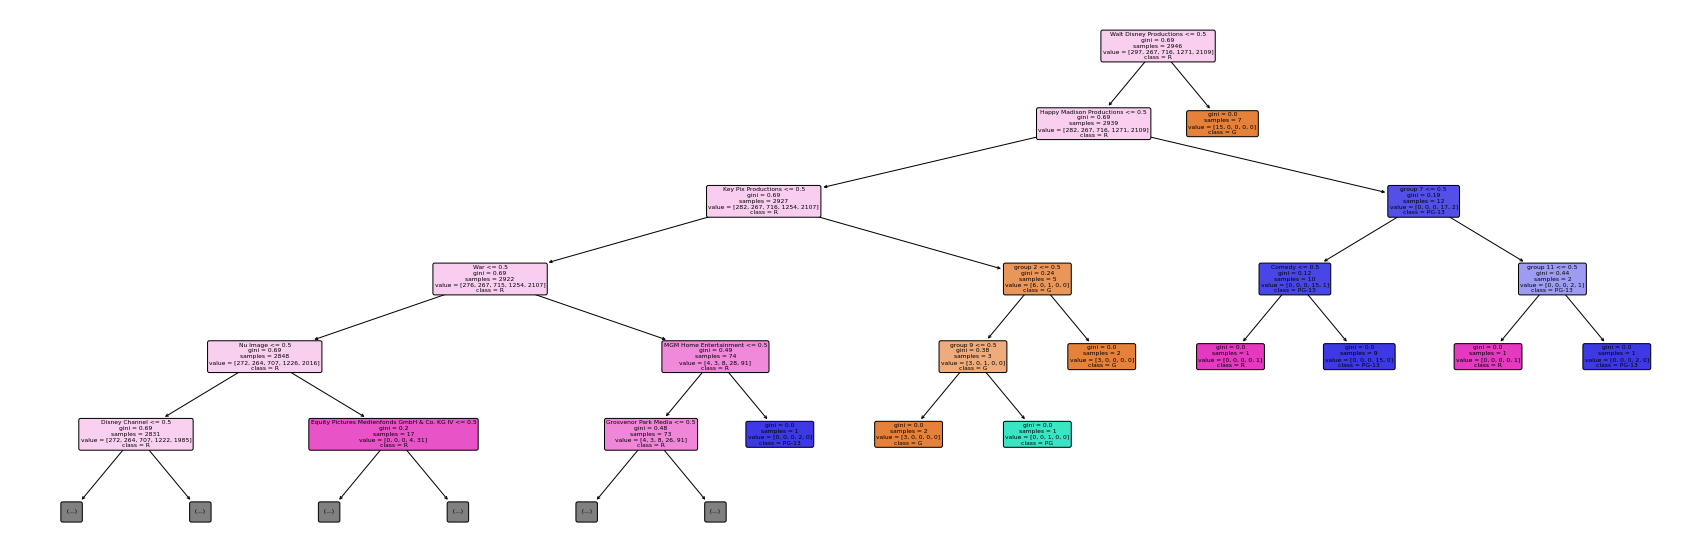

In [100]:
fig = plt.figure(figsize=(30,10))
tree.plot_tree(clf_E.estimators_[45], 
                feature_names = X_train.columns,
                class_names = ['G','NC-17','PG','PG-13','R'],
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=5, fontsize = 6)
plt.savefig("decision_tree3.png", facecolor = 'white',dpi=100)

plt.show()

Due to the decision Trees are super large, here we just show a few insights<br />

From the third Tree,  <br />
we can see that if a movie is produced by Walt Disney Production, it is classified as G by Tree-45th <br />
If A movie is produced by Happy Madison Production (not disney), with keywords from Group 7 and Group 11, it is classifed as PG-13<br />
If a movie is produce by Happy Madison Produciton , but does not have keywords from Group 7 and it is not Comedy, Then it will be classified as R <br />

#### Final Insights
We just show 3 trees out of 100 trees. The decision will be made based on average of all the trees, so the above insights are not final decision of the random forest. <br />

However, we know that a feature alone cannot give any decision meaning, only when difference features comes together, it will produce difference meaning. <br />

For example, The Drama Genre with different combinations formed different decision (by different tree)
Genre - Drama produced by  Red Chillies Entertainment (not by Syncopy)  will be classifed as PG-13 by 1st tree <br />
Genre - Drama produced by  Illumination Entertainment (not paramount and anomynous content)  will be classifed as PG by 10th Tree<br />

## Model as a Recommendation System
Now, I would like to create a few movie, <br />
Let say: <br />
Movie_A with runtime  100 minutes, budget 10M, a movie with a criminal was board on a boat with others passenger and they meet shark attacks in the middle of sea.

Movie_B with runtime  200 minutes, budget 400000M, a Walt Disney Pictures production, a animation movie with a young child with the ability of controlling god to help people that needs help

Movie_C with runtime 250 minutes, budget 400M,produced by Pimlico films a movie that is space colony and space exploration

Movie_D with runtime 60 minutes, budget 0, a movie that contain high possiblity of NC-17 content

In [124]:
new_movie = {'id':[11011,121,1212,123],
            'runtime':[100,200,250,60], 
           'budget':[10000000, 400000000000, 400000000, 0], 
           'keywords':[ ['crime scene','shark attack', 'falling in love', 'fish', 'police', ' criminal', 'dangerous'],
                        ['musical', 'friendship', 'children', 'educational','walt disney world'],
                        ['family','space', 'anti war','magic', 'space colony', 'evolution','explorer','artificial intelligence', 'space station', 'space', 'asteroid', 'cartoon'],
                        ['pornography','gay teen','sexual violence', 'male homosexuality','fetish','bdsm']], 
           'production_companies':[[],['Walt Disney Pictures','Walt Disney Animation Studios'],['Pimlico Films'],[]], 
            'genres':[['Crime','Horror','Action','Documentary'], ['Music','Family','Animation'],['Family','Adventure','Science Fiction'],['Documentary']]
          }
new_movie = pd.DataFrame(new_movie)
new_movie 

,id,runtime,budget,keywords,production_companies,genres
0,11011,100,10000000,"[crime scene, shark attack, falling in love, f...",[],"[Crime, Horror, Action, Documentary]"
1,121,200,400000000000,"[musical, friendship, children, educational, w...","[Walt Disney Pictures, Walt Disney Animation S...","[Music, Family, Animation]"
2,1212,250,400000000,"[family, space, anti war, magic, space colony,...",[Pimlico Films],"[Family, Adventure, Science Fiction]"
3,123,60,0,"[pornography, gay teen, sexual violence, male ...",[],[Documentary]


In [125]:
hash_group = []
for keyword_list in new_movie['keywords']:
    new =[]
    for keyword in keyword_list:
        j = 0
        for g in groups:
            if keyword in g:
                new.append("group " + str(j+1) )
                break
            j+=1
    hash_group.append(new)
new_movie['keywords']=hash_group

new_movie = one_hot_encoding(new_movie)
for columns in X_test.columns:
    if(columns not in new_movie.columns):
        new_movie[columns]=[0,0,0,0]
new_movie


,runtime,budget,group 11,group 12,group 13,group 14,group 15,group 17,group 18,group 2,...,saban,shanghai gigantic pictures,td.,truTV,uFilm,uFund,uMedia Family,ufotable,Ánima Estudios,Árpád Productions
0,100,10000000,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,200,400000000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,250,400000000,0,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,60,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
predict_test = pd.DataFrame(clf_E.predict(new_movie), columns=['Age Rating'])
predict_test

,Age Rating
0,R
1,PG-13
2,R
3,NC-17


We can see that 
Movie_A with criminal shark and surivor in sea as theme are clasified by R, so we can have a rough idea of the movie<br />
Movie_B with disney and animation are clasified as PG-13 <br />
Movie_C with space exploration are clasified R <br />
Movie_D with a movie that contain high possiblity of NC-17 content is really classfied as NC-17<br />


So we can see that the model can be used as a recommendation system 


## Final Conclusion
Our model have 69% Accuracy with relatively balanced prediction in each classes <br />

Runtime and budget are important features and followed by Genres then keywords <br />

Features alone does not give meaning, combination of features will give meaning of what the age rating be liked , and there are 100 decision trees that does their own decision, then random forest will give us the average result.

Model can be used as a recommendation system to give a benchmark for decision making and movie creator (as stated in our data_curation.ipnyb) 
